# Statistical Arbitrage Cointegration

## Strategy

We find pairs of coins that are cointegrated using the augmented Engle-Granger two-step cointegration test via the `coint` function of [the `statsmodels.tsa.stattools` module](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.coint.html). We then employ pairs trading for the pairs we find.

## Method, Fixed Cointegrated Pairs

- Select the top cryptocurrencies from December 2020 and use historical price data from December 2020 to August 31, 2025. (We use data from December 2020 to avoid lookahead bias for our selection of cryptocurrencies in the universe.)
- Use the Engle-Granger two-step method to identify cointegrated pairs over the interval from December 2020 to December 2022.
- 


- Use the Engle-Granger two-step method to find cointegrated pairs over a trailing window of x weeks (x to be determined from experimentation) with a significance level $\alpha$ to be determined.
- Re-calculate the hedge ratio over periods of y weeks (y to be determined) and trade the spread between pairs of cointegrated coins during the training period.
- Analyze the results over the training period and select the variations of x, y, and $\alpha$ with the highest sharpe ratios (which should hopefully also have manageable maximum drawdown durations). Run those variations during the testing period.

## Data Collection

## Implementation

## Transaction Costs

## Results

TO BE FILLED IN

# Imports

In [1]:
import pandas as pd
import numpy as np

from ipynb.fs.full.utility_functions import (
    get_price_data,
    calculate_covariance_directly,
)
from statsmodels.tsa.stattools import coint

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Price Data Collection

In [2]:
univ = [
    "BTCUSDT", "ETHUSDT", "ADAUSDT", "BNBUSDT", "XRPUSDT", "DOTUSDT", "MATICUSDT", "LTCUSDT", "BCHUSDT",
    "LINKUSDT", "XLMUSDT", "USDCUSDT", "EOSUSDT", "TRXUSDT", "XTZUSDT", "FILUSDT", "NEOUSDT", "DAIUSDT",
    "DASHUSDT", "VETUSDT", "ATOMUSDT", "AAVEUSDT", "UNIUSDT", "GRTUSDT", "THETAUSDT", "IOTAUSDT", "BUSDUSDT",
    "ZECUSDT", "YFIUSDT", "ETCUSDT", "WAVESUSDT", "COMPUSDT", "SNXUSDT", "DOGEUSDT", "MKRUSDT", "ZILUSDT",
    "SUSHIUSDT", "KSMUSDT", "OMGUSDT", "ONTUSDT", "ALGOUSDT", "EGLDUSDT", "BATUSDT", "DGBUSDT", "ZRXUSDT",
    "TUSDUSDT", "QTUMUSDT", "ICXUSDT", "AVAXUSDT", "RENUSDT", "HBARUSDT", "NEARUSDT", "LRCUSDT", "CELOUSDT",
    "KNCUSDT", "LSKUSDT", "OCEANUSDT", "QNTUSDT", "USTUSDT", "BANDUSDT", "MANAUSDT", "ENJUSDT", "ANTUSDT",
    "BNTUSDT", "ZENUSDT", "NMRUSDT", "RVNUSDT", "IOSTUSDT", "OXTUSDT", "CRVUSDT", "MATICUSDT", "HNTUSDT",
    "BALUSDT", "CHZUSDT"
]

px = get_price_data(univ, '4h', True, './class_project_input_prices.csv')
px

,BTCUSDT,ETHUSDT,ADAUSDT,BNBUSDT,XRPUSDT,DOTUSDT,MATICUSDT,LTCUSDT,BCHUSDT,LINKUSDT,...,BNTUSDT,ZENUSDT,NMRUSDT,RVNUSDT,IOSTUSDT,OXTUSDT,CRVUSDT,HNTUSDT,BALUSDT,CHZUSDT
open_time,,,,,,,,,,,,,,,,,,,,,
2020-12-20 00:00:00,23353.97,646.62,0.16284,32.9681,0.56944,NaN,NaN,117.34,313.46,NaN,...,NaN,12.056,NaN,NaN,NaN,0.2492,NaN,1.41095,NaN,NaN
2020-12-20 04:00:00,23604.24,655.23,0.16638,33.6559,0.57916,NaN,NaN,121.30,340.00,NaN,...,NaN,12.107,NaN,NaN,NaN,0.2477,NaN,1.43156,NaN,NaN
2020-12-20 08:00:00,23549.50,652.88,0.16463,34.8228,0.57948,NaN,NaN,118.09,349.70,NaN,...,NaN,12.237,NaN,NaN,NaN,0.2477,NaN,1.44273,NaN,NaN
2020-12-20 12:00:00,23880.85,653.24,0.16542,35.0120,0.57798,NaN,NaN,119.10,361.21,NaN,...,NaN,12.074,NaN,NaN,NaN,0.2533,NaN,1.47130,NaN,NaN
2020-12-20 16:00:00,23932.71,649.82,0.16502,34.7042,0.57306,NaN,NaN,116.60,357.09,NaN,...,NaN,12.008,NaN,NaN,NaN,0.2503,NaN,1.43083,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-30 16:00:00,108921.64,4352.10,0.81950,856.7600,2.80720,3.816,NaN,110.23,542.00,23.36,...,0.725,7.240,16.62,0.01323,0.00342,0.0535,0.7646,NaN,NaN,0.03830
2025-08-30 20:00:00,108569.75,4374.56,0.82170,862.6200,2.81940,3.773,NaN,110.77,552.90,23.47,...,0.725,7.240,15.16,0.01323,0.00342,0.0535,0.7646,NaN,NaN,0.03830
2025-08-31 00:00:00,109155.73,4486.79,0.83590,863.4900,2.85180,3.867,NaN,111.67,551.30,23.90,...,0.764,7.240,15.21,0.01353,0.00342,0.0535,0.7936,NaN,NaN,0.04045


# Utility Functions

In [3]:
def find_cointegrated_pairs(data, significance_level=0.05):
    """
    Finds cointegrated pairs using the Engle-Granger two-step method.
    Returns a list of cointegrated pairs with their p-value.
    """
    n = data.shape[1]
    keys = data.columns
    pvalue_matrix = pd.DataFrame(np.ones((n, n)), index=keys, columns=keys)
    pairs = []

    for i in range(n):
        for j in range(i + 1, n):
            series1 = data[keys[i]]
            series2 = data[keys[j]]
            
            joint_non_na_series1 = series1.loc[series1.notna() & series2.notna()]
            joint_non_na_series2 = series2.loc[series1.notna() & series2.notna()]
            
            if len(joint_non_na_series1) == 0 or len(joint_non_na_series2) == 0:
                pvalue_matrix.loc[keys[i], keys[j]] = 1.0
                continue

            # Perform the cointegration test
            score, pvalue, _ = coint(joint_non_na_series1, joint_non_na_series2)
            pvalue_matrix.loc[keys[i], keys[j]] = pvalue

            if pvalue < significance_level:
                pairs.append((keys[i], keys[j], pvalue))
    return pvalue_matrix, pairs

# Collect Signal Values

In [ ]:
input_prices = px
step = 60
significance_level = 0.05

# pvalue_matrix, pairs = find_cointegrated_pairs(px)


for index in range(len(input_prices)):
    if index < step or index % step != 0:
        continue
    
    pvalue_matrix, pairs = find_cointegrated_pairs(input_prices.iloc[(index-step):index], significance_level)
    
    if len(pairs) > 0:
        break

In [5]:
pairs

[('ADAUSDT', 'BNBUSDT', 0.0012176097656445876),
 ('ADAUSDT', 'ATOMUSDT', 0.02441681103471223),
 ('ADAUSDT', 'MKRUSDT', 0.015862065528658792),
 ('BNBUSDT', 'VETUSDT', 0.004838107317604351),
 ('BCHUSDT', 'MKRUSDT', 0.030264326618768527),
 ('BCHUSDT', 'ZENUSDT', 0.02806255864014769),
 ('XLMUSDT', 'BUSDUSDT', 0.008380105231874546),
 ('XLMUSDT', 'BATUSDT', 0.03926608461163476),
 ('NEOUSDT', 'ETCUSDT', 0.03548890811554676),
 ('NEOUSDT', 'COMPUSDT', 0.041978699212760893),
 ('NEOUSDT', 'ONTUSDT', 0.005313406615044296),
 ('NEOUSDT', 'QTUMUSDT', 9.668759310017008e-05),
 ('NEOUSDT', 'KNCUSDT', 0.00011147463174915685),
 ('ETCUSDT', 'ZRXUSDT', 0.02588025129782575),
 ('ETCUSDT', 'QTUMUSDT', 0.012207542661572644),
 ('ETCUSDT', 'KNCUSDT', 2.3134264220349568e-05),
 ('COMPUSDT', 'ONTUSDT', 0.015293115136608304),
 ('COMPUSDT', 'QTUMUSDT', 0.0018090061254333266),
 ('COMPUSDT', 'BANDUSDT', 1.9255858505916554e-07),
 ('COMPUSDT', 'OXTUSDT', 0.04590406508803817),
 ('DOGEUSDT', 'MKRUSDT', 0.028300000423330397)

In [6]:
index

60

In [7]:
input_prices.iloc[0:60][["ADAUSDT", "BNBUSDT"]]

,ADAUSDT,BNBUSDT
open_time,,
2020-12-20 00:00:00,0.16284,32.9681
2020-12-20 04:00:00,0.16638,33.6559
2020-12-20 08:00:00,0.16463,34.8228
2020-12-20 12:00:00,0.16542,35.0120
2020-12-20 16:00:00,0.16502,34.7042
2020-12-20 20:00:00,0.16192,34.0932
2020-12-21 00:00:00,0.16214,35.4842
2020-12-21 04:00:00,0.16339,34.4445
2020-12-21 08:00:00,0.15109,32.3250


In [8]:
strat_data = pd.DataFrame()

spread_data = pd.Series()
beta_data = pd.Series()

for index in range(step):
    spread_data[input_prices.index[index]] = np.nan
    beta_data[input_prices.index[index]] = np.nan

for index in range(step, len(input_prices)):
    ada_prices = input_prices.iloc[(index-step+1):(index+1)]["ADAUSDT"]
    bnb_prices = input_prices.iloc[(index-step+1):(index+1)]["BNBUSDT"]
    calculated_cov = calculate_covariance_directly(ada_prices, bnb_prices)
    
    beta = calculated_cov / bnb_prices.var()
    
    spread = input_prices.iloc[index]["ADAUSDT"] - beta * input_prices.iloc[index]["BNBUSDT"]
    spread_data[input_prices.index[index]] = spread
    beta_data[input_prices.index[index]] = beta
    
strat_data["spread"] = spread_data
strat_data["beta"] = beta_data

In [9]:
# performance_data = pd.DataFrame({
#     "spread": spread_data
# })

# z_score = (performance_data - performance_data.rolling(step).mean()) / performance_data.rolling(step).std()

# performance_data["z_score"] = z_score
# performance_data

z_score = (strat_data["spread"] - strat_data["spread"].rolling(step).mean()) / strat_data["spread"].rolling(step).std()
strat_data["z-score"] = z_score

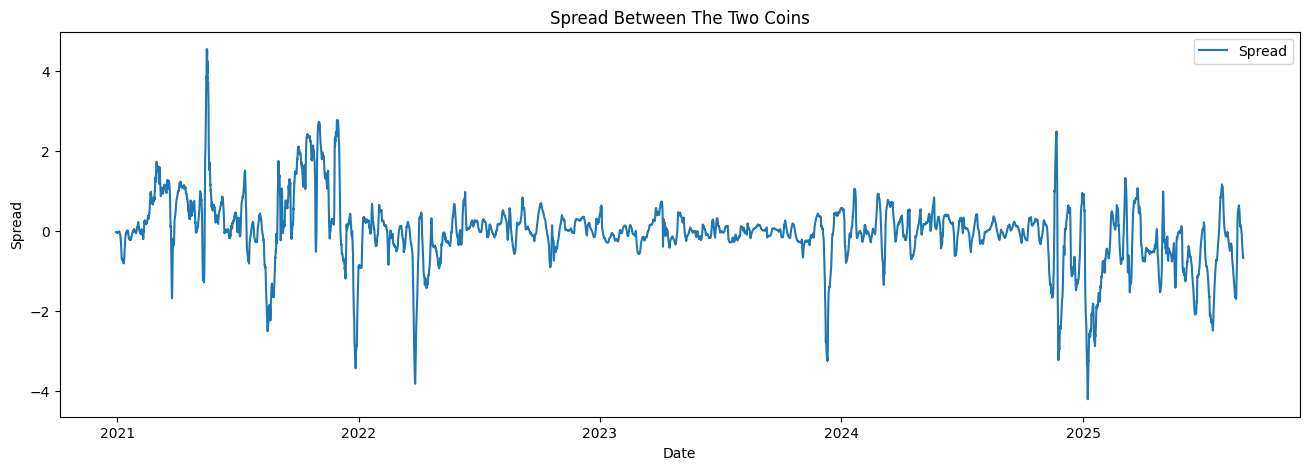

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 5))

plt.plot(strat_data["spread"], label='Spread')
# plt.axhline(pair_data.mean(), label="Spread Mean", color="black")
plt.title('Spread Between The Two Coins')
plt.xlabel('Date')
plt.ylabel('Spread')

plt.legend()
plt.show()

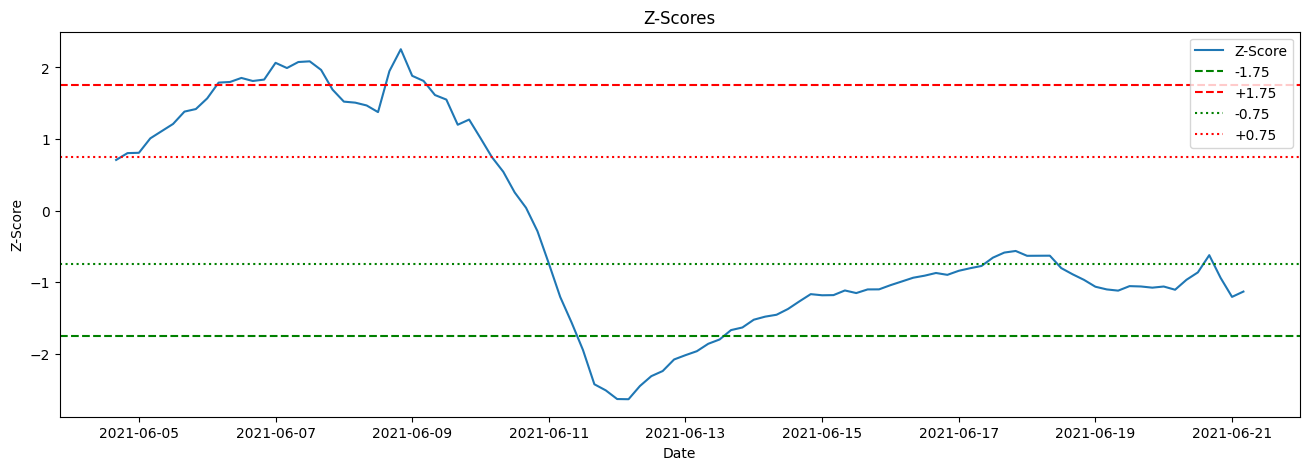

In [58]:
plt.figure(figsize=(16, 5))

plt.plot(strat_data["z-score"].iloc[1000:1100], label='Z-Score')
# plt.axhline(pair_data.mean(), label="Spread Mean", color="black")
plt.title('Z-Scores')
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.axhline(-1.75, color="green", linestyle="--", label="-1.75")
plt.axhline(1.75, color="red", linestyle="--", label="+1.75")
plt.axhline(-0.75, color="green", linestyle="dotted", label="-0.75")
plt.axhline(0.75, color="red", linestyle="dotted", label="+0.75")

plt.legend()
plt.show()

In [12]:
strat_data

,spread,beta,z-score
2020-12-20 00:00:00,NaN,NaN,NaN
2020-12-20 04:00:00,NaN,NaN,NaN
2020-12-20 08:00:00,NaN,NaN,NaN
2020-12-20 12:00:00,NaN,NaN,NaN
2020-12-20 16:00:00,NaN,NaN,NaN
...,...,...,...
2025-08-30 16:00:00,-0.624644,0.001686,-1.136728
2025-08-30 20:00:00,-0.633977,0.001688,-1.246016
2025-08-31 00:00:00,-0.618255,0.001684,-1.295105
2025-08-31 04:00:00,-0.628828,0.001696,-1.383112


In [40]:
money_earned = 0.0

shifted_forward_strat_data = strat_data.shift()

balance_record = pd.Series()

ada_share_count = 0
bnb_share_count = 0.0

# ADA ~ BNB * b + a
# long 1 ADA, short b BNB

for i in range(len(shifted_forward_strat_data)):
    open_time = shifted_forward_strat_data.index[i]
    is_currently_holding = ada_share_count != 0
    z_score = shifted_forward_strat_data.iloc[i]["z-score"]
    beta = shifted_forward_strat_data.iloc[i]["beta"]
    
    if z_score is None or np.isnan(z_score):
        ada_share_count = 0
        bnb_share_count = 0.0
    elif z_score > 1.75 and not is_currently_holding: # ADA currently overpriced, BNB underpriced
        ada_share_count = -1
        bnb_share_count = beta
        money_earned -= (ada_share_count * px.iloc[i-1]['ADAUSDT'] + bnb_share_count * px.iloc[i-1]['BNBUSDT'])
    elif z_score < -1.75 and not is_currently_holding: # ADA currently underpriced, BNB overpriced
        ada_share_count = +1
        bnb_share_count = -beta
        money_earned -= (ada_share_count * px.iloc[i-1]['ADAUSDT'] + bnb_share_count * px.iloc[i-1]['BNBUSDT'])
    elif is_currently_holding and abs(z_score) < 0.75:
        money_earned += ada_share_count * px.iloc[i]['ADAUSDT'] + bnb_share_count * px.iloc[i]['BNBUSDT']
        ada_share_count = 0
        bnb_share_count = 0.0
    
    current_position = ada_share_count * px.iloc[i]['ADAUSDT'] + bnb_share_count * px.iloc[i]['BNBUSDT']
    balance_record[open_time] = money_earned + current_position

balance_record

2020-12-20 00:00:00    0.000000
2020-12-20 04:00:00    0.000000
2020-12-20 08:00:00    0.000000
2020-12-20 12:00:00    0.000000
2020-12-20 16:00:00    0.000000
                         ...   
2025-08-30 16:00:00    1.460666
2025-08-30 20:00:00    1.460666
2025-08-31 00:00:00    1.460666
2025-08-31 04:00:00    1.460666
2025-08-31 08:00:00    1.460666
Length: 10291, dtype: float64

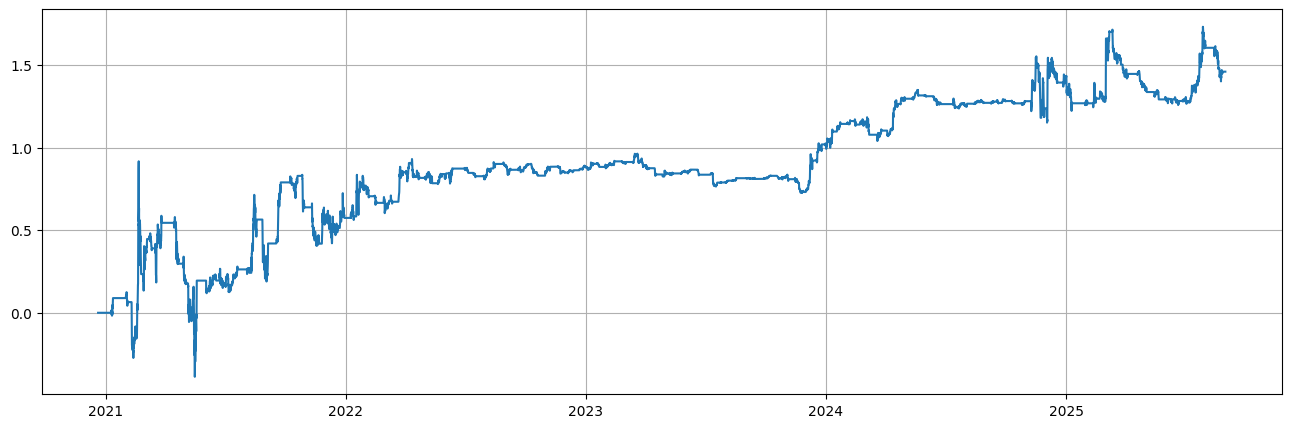

In [41]:
plt.figure(figsize=(16,5))
plt.plot(balance_record)

plt.grid()
plt.show()

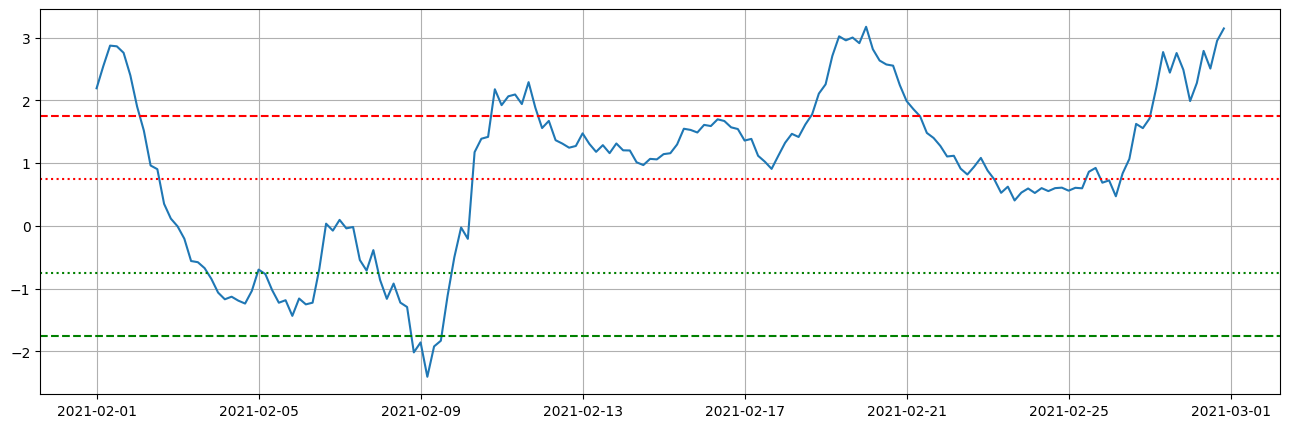

In [64]:
plt.figure(figsize=(16,5))
plt.plot(strat_data["z-score"].loc[datetime(2021, 2, 1, 0, 0):datetime(2021, 2, 28, 20, 0)])

plt.axhline(-1.75, color="green", linestyle="--", label="-1.75")
plt.axhline(1.75, color="red", linestyle="--", label="+1.75")
plt.axhline(-0.75, color="green", linestyle="dotted", label="-0.75")
plt.axhline(0.75, color="red", linestyle="dotted", label="+0.75")

plt.grid()
plt.show()

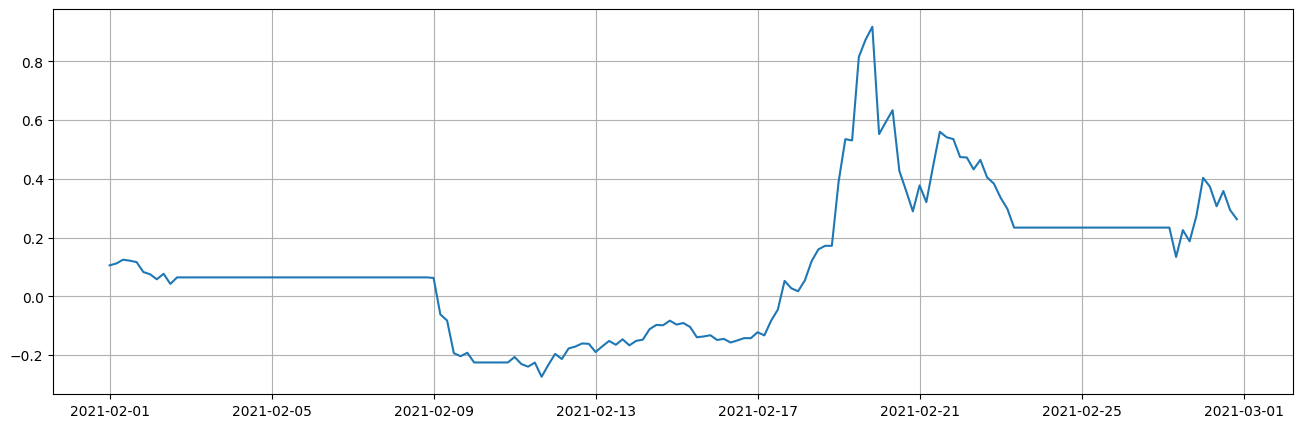

In [65]:
from datetime import datetime

plt.figure(figsize=(16,5))
plt.plot(balance_record.loc[datetime(2021, 2, 1, 0, 0):datetime(2021, 2, 28, 20, 0)])

plt.grid()
plt.show()

# balance_ret = balance_record / balance_record.shift() - 1

# non_inf_balance_ret = balance_ret[balance_ret != float('inf')]
# non_inf_balance_ret.mean() / non_inf_balance_ret.std() * np.sqrt(365 * 6)

In [52]:
strat_data["z-score"].loc[datetime(2021, 1, 1, 0, 0)]

nan